<a href="https://colab.research.google.com/github/pedroconcejero/deep_learning_2024/blob/main/699_sequence_models_embeddings_bullying_2024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Modelo RNN-LSTM para detección de bullying

Noviembre 2024

Este notebook intenta replicar un modelo de clasificación de texto para detectar bullying, basado en deep learning (modelos de red neuronal recurrente; LSTM). Más en concreto está basado en un notebook propuesto por Chollet en su libro [Deep Learning with Python, Second Edition](https://www.manning.com/books/deep-learning-with-python-second-edition?a_aid=keras&a_bid=76564dff).

El objetivo en este caso es aplicarlo a un problema mucho más preocupante que el original (comentarios positivos o negativos a películas en IMDB), como es el lenguaje de odio, o el uso del lenguaje a través de redes sociales para atacar a otras personas. Algo conocido recientemente como bullying o cyberbullying.

Para este propósito hay muchos conjuntos en kaggle y otros sitios:

https://hatespeechdata.com/

https://www.sciencedirect.com/science/article/pii/S2352340922010356?via%3Dihub

Pero he escogido el siguiente conjunto por simplicidad y porque hay un trabajo muy interesante desarrollado con metodología de text mining tradicional (sin redes neuronales) y que proporciona resultados para un conjunto muy amplio de modelos:

https://github.com/tazeek/BullyDetect

También hay código basado en este otro trabajo sobre "hate_speech":
https://www.kaggle.com/code/nickkatsarelas/hate-speech-and-offensive-langauge-lstm

Las hipótesis u objetivos de este trabajo serán:

- ¿Podemos usar *tal cual* el modelo propuesto por Chollet para este conjunto de datos.
- ¿Es su tamaño suficiente para este tipo de entrenamientos de modelos?
- ¿Podemos conseguir igualar el rendimiento de modelos tradicionales sin el costoso pre-proceso que normalmente requieren estos?

Veamos:

### 1. Carga de librerías necesarias

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


Este notebook requiere abrir nltk y varias otras librerías de NLP


In [3]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
import string
import pandas as pd
import warnings
from nltk.tokenize import word_tokenize
warnings.filterwarnings("ignore")
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("punkt")
nltk.download("omw-1.4")
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from textblob import TextBlob

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


### 2. Downloading and pre-processing the data



In [4]:
df = pd.read_csv('https://raw.githubusercontent.com/t-davidson/hate-speech-and-offensive-language/refs/heads/master/data/labeled_data.csv',
                 delimiter = ',',
                 header = 0)

In [5]:
df.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [6]:
df.drop(['Unnamed: 0','count'],
        axis = 1,
        inplace = True)
df.duplicated().sum()

0

In [7]:
df.isna().sum()


,0
hate_speech,0
offensive_language,0
neither,0
class,0
tweet,0


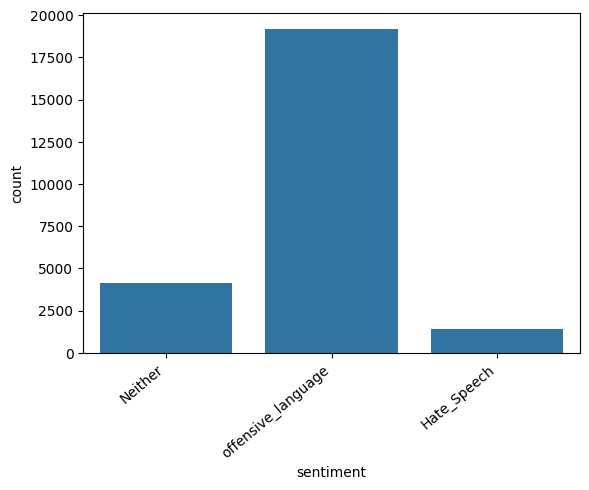

In [8]:

df['sentiment'] = df['class'].map({0:'Hate_Speech',1:'offensive_language',
                                  2: 'Neither'})


fig, axs = plt.subplots(figsize=(6,5))
sns.countplot(x='sentiment',data=df,ax=axs)
axs.set_xticklabels(axs.get_xticklabels(),rotation=40,ha="right")
plt.tight_layout()
plt.show()

Limpieza de texto (esto no lo habíamos hecho anteriormente)

In [9]:
def clean_text(text):
    text = str(text).lower()
    text = re.sub('<.*?>+', '',text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('rt', '',text)
    text = re.sub('\d', '',text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub('  ',' ',text)
    return text

df['tweet'] = df['tweet'].apply(clean_text)
df['tweet'].head(10)

,tweet
0,mayasolovely as a woman you shouldnt complain...
1,mleew boy dats coldtyga dwn bad for cuffin da...
2,urkindofbrand dawg sbabylife you ever fuck a ...
3,cganderson vivabased she look like a tranny
4,shenikarobes the shit you hear about me might...
5,tmadisonx the shit just blows meclaim you so f...
6,brighterdays i can not just sit up and hate on...
7,selfiequeenbri cause im tired of you big bitch...
8,amp you might not get ya bitch back amp thats...
9,rhythmixx hobbies include fighting mariam\n\n...


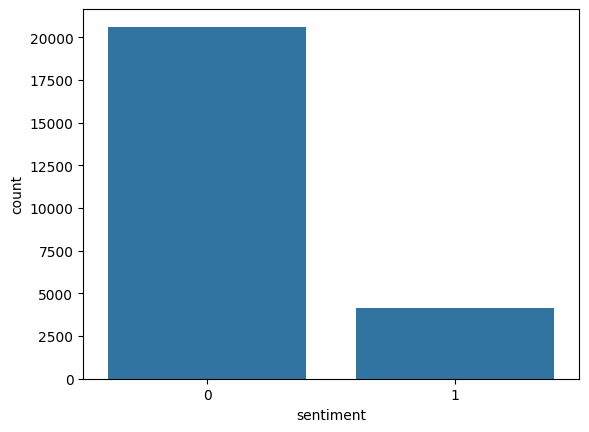

In [10]:
Hate_tweet = (df['sentiment'] == "Hate_Speech").astype('int32')
neither = (df['sentiment'] == "Neither").astype('int32')

sns.countplot(x=neither)
plt.show()


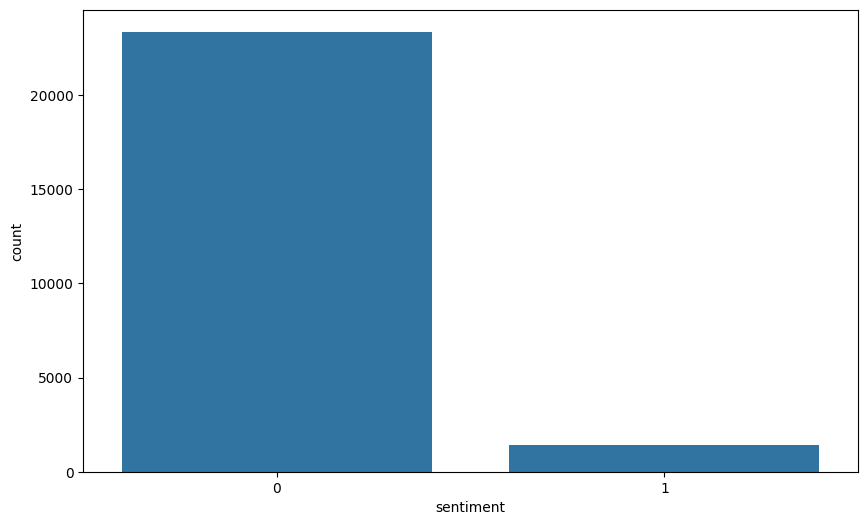

In [11]:
plt.figure(figsize=(10,6))
sns.countplot(x=Hate_tweet)
plt.xticks()
plt.show()

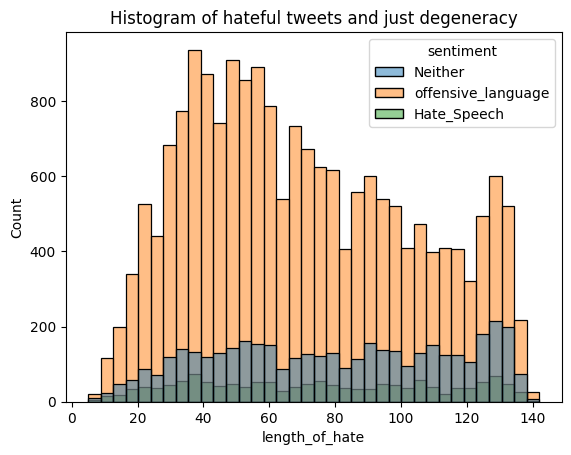

In [12]:
df['length_of_hate'] = df['tweet'].apply(len)

sns.histplot(x='length_of_hate',hue='sentiment',data=df)
plt.title('Histogram of hateful tweets and just degeneracy')
plt.show()

### Preparar conjuntos train / test para X e y

In [13]:
X = df['tweet']
y = df['class']

from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.15, random_state=42)

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Embedding, Dense, SpatialDropout1D, Bidirectional
from tensorflow.keras.utils import to_categorical


y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

tokenizer = Tokenizer()

tokenizer.fit_on_texts(X_train)

word_index = tokenizer.word_index

In [14]:
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

max_length = 0
for sequence in X_train:
    sequence_length = len(sequence)
    if sequence_length > max_length:
        max_length = sequence_length


print(max_length)

33


**Preparing integer sequence datasets**

In [15]:
from tensorflow.keras.utils import pad_sequences

X_train = pad_sequences(X_train, maxlen=max_length, padding='post')
X_test = pad_sequences(X_test, maxlen=max_length, padding='post')

#### Understanding word embeddings

#### Learning word embeddings with the Embedding layer

**Model that uses an `Embedding` layer trained from scratch**

In [16]:
RNN = Sequential()
RNN.add(Embedding(len(word_index) + 1,
                  output_dim = 33, input_length = 33))
RNN.add(SpatialDropout1D(0.2))
RNN.add(Bidirectional(LSTM(33,
                           dropout=0.2,
                           recurrent_dropout=0.2)))
RNN.add(Dense(3, activation = 'softmax'))
RNN.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout1d (SpatialDropout1D) │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [17]:
RNN.compile(loss='categorical_crossentropy',
            optimizer='adam',
            metrics=['accuracy'])
batch_size = 64



In [18]:
history = RNN.fit(X_train,
                  y_train,
                  batch_size=batch_size,
                  epochs=10,
                  validation_split=0.1)


Epoch 1/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 42s 108ms/step - accuracy: 0.7678 - loss: 0.6631 - val_accuracy: 0.8913 - val_loss: 0.3314
Epoch 2/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 35s 116ms/step - accuracy: 0.8929 - loss: 0.3266 - val_accuracy: 0.9056 - val_loss: 0.2964
Epoch 3/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 32s 107ms/step - accuracy: 0.9232 - loss: 0.2403 - val_accuracy: 0.9027 - val_loss: 0.3024
Epoch 4/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 34s 114ms/step - accuracy: 0.9341 - loss: 0.1928 - val_accuracy: 0.9032 - val_loss: 0.2991
Epoch 5/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 40s 110ms/step - accuracy: 0.9563 - loss: 0.1339 - val_accuracy: 0.9003 - val_loss: 0.3248
Epoch 6/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 40s 109ms/step - accuracy: 0.9711 - loss: 0.0930 - val_accuracy: 0.8956 - val_loss: 0.3668
Epoch 7/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 40s 107ms/step - accuracy: 0.9809 - loss: 0.0634 - val_accuracy: 0.8904 - val_loss: 0.4081
Epoch 8/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 44s 116ms/step - accuracy: 0.9856 - loss: 0

In [19]:
results = RNN.evaluate(X_test,y_test)
pred = RNN.predict(X_test)
print(results)
print("Max Accuracy: ",max(history.history['accuracy']))
print("Max vallidation accuracy: ",max(history.history['val_accuracy']))



117/117 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.8787 - loss: 0.5578
117/117 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step
[0.5542112588882446, 0.8754706978797913]
Max Accuracy:  0.9891866445541382
Max vallidation accuracy:  0.9055529236793518


#### Understanding padding and masking

**Using an `Embedding` layer with masking enabled**

In [ ]:
inputs = keras.Input(shape=(None,), dtype="int64")
embedded = layers.Embedding(
    input_dim=max_tokens,
    output_dim=256,
    mask_zero=True)(inputs)
x = layers.Bidirectional(layers.LSTM(32))(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

callbacks = [
    keras.callbacks.ModelCheckpoint("embeddings_bidir_gru_with_masking.keras",
                                    save_best_only=True)
]
model.fit(int_train_ds, validation_data=int_val_ds, epochs=10, callbacks=callbacks)

print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_3 (Embedding)   │ (None, None, 256)      │      2,560,000 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal_1 (NotEqual)    │ (None, None)           │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_2           │ (None, 64)             │         73,984 │ embedding_3[0][0],     │
│ (Bidirectional)           │                        │                │ not_equal_1[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 64)             │              0 │ bidirectional_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 1)              │             65 │ dropout_2[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 2,634,049 (10.05 MB)

 Trainable params: 2,634,049 (10.05 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 19s 28ms/step - accuracy: 0.6706 - loss: 0.5766 - val_accuracy: 0.8548 - val_loss: 0.3478
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 27ms/step - accuracy: 0.8561 - loss: 0.3418 - val_accuracy: 0.8790 - val_loss: 0.2972
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - accuracy: 0.8909 - loss: 0.2760 - val_accuracy: 0.8718 - val_loss: 0.3083
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 27ms/step - accuracy: 0.9094 - loss: 0.2316 - val_accuracy: 0.8774 - val_loss: 0.3197
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 28ms/step - accuracy: 0.9298 - loss: 0.1881 - val_accuracy: 0.8796 - val_loss: 0.3178
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 27ms/step - accuracy: 0.9461 - loss: 0.1525 - val_accuracy: 0.8758 - val_loss: 0.3486
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 27ms/step - accuracy: 0.9596 - loss: 0.1169 - val_accuracy: 0.8580 - val_loss: 0.4333
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - accuracy: 0.9715 - loss: 0.0831 - 

#### Using pretrained word embeddings

In [ ]:
!wget https://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2024-11-14 19:52:57--  https://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2024-11-14 19:52:57--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  5.09MB/s    in 2m 43s  

2024-11-14 19:55:41 (5.04 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]



**Parsing the GloVe word-embeddings file**

In [ ]:
import numpy as np
path_to_glove_file = "glove.6B.100d.txt"

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print(f"Found {len(embeddings_index)} word vectors.")

Found 400000 word vectors.


**Preparing the GloVe word-embeddings matrix**

In [ ]:
embedding_dim = 100

vocabulary = text_vectorization.get_vocabulary()
word_index = dict(zip(vocabulary, range(len(vocabulary))))

embedding_matrix = np.zeros((max_tokens, embedding_dim))

for word, i in word_index.items():
    if i < max_tokens:
        embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [ ]:
embedding_layer = layers.Embedding(
    max_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
    mask_zero=True,
)

**Model that uses a pretrained Embedding layer**

In [ ]:
inputs = keras.Input(shape=(None,), dtype="int64")
embedded = embedding_layer(inputs)
x = layers.Bidirectional(layers.LSTM(32))(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

callbacks = [
    keras.callbacks.ModelCheckpoint("glove_embeddings_sequence_model.keras",
                                    save_best_only=True)
]
model.fit(int_train_ds, validation_data=int_val_ds, epochs=10, callbacks=callbacks)

print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_4 (Embedding)   │ (None, None, 100)      │      1,000,000 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal_2 (NotEqual)    │ (None, None)           │              0 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_3           │ (None, 64)             │         34,048 │ embedding_4[0][0],     │
│ (Bidirectional)           │                        │                │ not_equal_2[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 64)             │              0 │ bidirectional_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 1)              │             65 │ dropout_3[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 1,034,113 (3.94 MB)

 Trainable params: 34,113 (133.25 KB)

 Non-trainable params: 1,000,000 (3.81 MB)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 30s 43ms/step - accuracy: 0.6064 - loss: 0.6480 - val_accuracy: 0.7212 - val_loss: 0.5228
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 33ms/step - accuracy: 0.7686 - loss: 0.4926 - val_accuracy: 0.8036 - val_loss: 0.4200
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 34ms/step - accuracy: 0.8024 - loss: 0.4345 - val_accuracy: 0.8220 - val_loss: 0.4035
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 33ms/step - accuracy: 0.8240 - loss: 0.4001 - val_accuracy: 0.8394 - val_loss: 0.3566
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 34ms/step - accuracy: 0.8372 - loss: 0.3710 - val_accuracy: 0.8548 - val_loss: 0.3286
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 39s 30ms/step - accuracy: 0.8492 - loss: 0.3531 - val_accuracy: 0.8544 - val_loss: 0.3288
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 30ms/step - accuracy: 0.8577 - loss: 0.3307 - val_accuracy: 0.8500 - val_loss: 0.3402
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 34ms/step - accuracy: 0.8687 - loss: 0.3192 - 